# Clustering to predict Market Regime

In this notebook we implement the clustering to predict the market regimes

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

We download the daily historical data for the S&P 500 index (`^GSPC`) starting from 1993. We focus specifically on the Close prices to capture market trends.

In [2]:
sp = yf.download("^GSPC", start="1993-10-01")
sp = sp[['Close']].copy()            
sp = sp.dropna()
sp.index = pd.to_datetime(sp.index) 
sp.columns = ['_'.join(col).strip() for col in sp.columns.values]
print(sp.columns)
sp = sp.rename(columns={'Close_^GSPC': 'Close'})
# print(sp.head(63))
print("Close type:", type(sp['Close']))
print("Close shape:", sp['Close'].shape)

/var/folders/l5/l2yq9xlj55l1p5qsn5c6n5wh0000gn/T/ipykernel_1982/123046917.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp = yf.download("^GSPC", start="1993-10-01")
[*********************100%***********************]  1 of 1 completed

Index(['Close_^GSPC'], dtype='object')
Close type: <class 'pandas.core.series.Series'>
Close shape: (8099,)


To characterize market stress, we calculate the Drawdown in the following way:
1.  We compute the maximum closing price over a rolling window of 63 trading days (approximately one quarter).
2.  We calculate the percentage decline from this rolling peak to the current price. This metric effectively captures the depth of market corrections.

In [3]:
window = 63
sp['rolling_peak'] = sp['Close'].rolling(window=window).max()
print(sp['rolling_peak'])
print("rolling_peak type:", type(sp['rolling_peak']))
print("rolling_peak shape:", sp['rolling_peak'].shape)

Date
1993-10-01            NaN
1993-10-04            NaN
1993-10-05            NaN
1993-10-06            NaN
1993-10-07            NaN
                 ...     
2025-11-26    6890.890137
2025-11-28    6890.890137
2025-12-01    6890.890137
2025-12-02    6890.890137
2025-12-03    6890.890137
Name: rolling_peak, Length: 8099, dtype: float64
rolling_peak type: <class 'pandas.core.series.Series'>
rolling_peak shape: (8099,)


In [4]:
sp['drawdown'] = (sp['Close'] - sp['rolling_peak']) / sp['rolling_peak']

Since our investment strategy operates on a monthly rebalancing frequency, we aggregate the daily drawdown data into monthly observations.
We select the Maximum Drawdown observed during each month to represent the worst-case stress level for that period.

In [5]:
dd_monthly = sp['drawdown'].resample('M').min().dropna()

df_dd = dd_monthly.to_frame().reset_index()
df_dd.columns = ['Date', 'Drawdown']

In [6]:
df_dd

,Date,Drawdown
0,1993-12-31,-0.009534
1,1994-01-31,-0.011679
2,1994-02-28,-0.036805
3,1994-03-31,-0.075622
4,1994-04-30,-0.089378
...,...,...
380,2025-08-31,-0.023751
381,2025-09-30,-0.013300
382,2025-10-31,-0.029793
383,2025-11-30,-0.051101


The plot below visualizes the historical 3-month rolling drawdown of the S&P 500. We can clearly observe major financial crises (e.g., 2000 Dot-com bubble, 2008 Global Financial Crisis, 2020 COVID-19) as deep spikes in the drawdown metric.

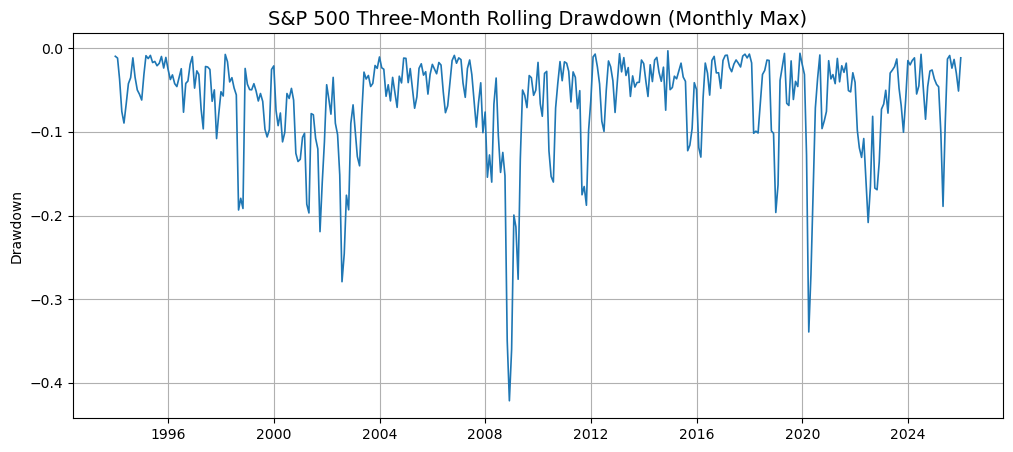

In [7]:
plt.figure(figsize=(12,5))
plt.plot(df_dd['Date'], df_dd['Drawdown'], linewidth=1.2)
plt.title("S&P 500 Three-Month Rolling Drawdown (Monthly Max)", fontsize=14)
plt.ylabel("Drawdown")
plt.grid(True)
plt.show()

We use the K-Means algorithm to group the monthly drawdown values into 3 clusters:
* We apply a log transformation (`log1p`) to the absolute drawdown values to handle the skewness of the distribution (since crashes are extreme outliers).
* After fitting the model, we analyze the cluster centroids to interpret the regimes. The cluster with the largest average drawdown corresponds to the "Bear" market, while the smallest corresponds to "Normal" conditions.

In [8]:
df_dd['DD_abs'] = df_dd['Drawdown'].abs()         
df_dd['DD_log'] = np.log1p(df_dd['DD_abs'])       
X = df_dd[['DD_log']].values

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=500)
df_dd['Regime'] = kmeans.fit_predict(X)

centroids = kmeans.cluster_centers_.flatten()
print("Centroids:", np.sort(centroids))

order = np.argsort(centroids)  # decending = worst
print(order)

Centroids: [0.02937485 0.08617351 0.18623101]
[1 2 0]


In [10]:
cluster_to_regime = {
    order[2]: "Bear",
    order[1]: "Correction",
    order[0]: "Normal"
}

df_dd['Cluster'] = df_dd['Regime'].map(cluster_to_regime)

df_dd = df_dd.drop(columns=['Regime', 'DD_abs'])

Finally, we map the numeric cluster IDs to meaningful labels:
* **0 (Normal):** Low volatility, uptrends.
* **1 (Correction):** Moderate pullbacks.
* **2 (Bear):** Deep market crashes.

The labeled dataset is saved as `market_regimes.csv` to be merged with macroeconomic data.

In [11]:
regime_map_numeric = {
    "Normal": 0,
    "Correction": 1,
    "Bear": 2
}

df_dd['Regime_num'] = df_dd['Cluster'].map(regime_map_numeric)

In [12]:
print(df_dd.head())
print(df_dd.tail())
print(df_dd['Cluster'].value_counts())

        Date  Drawdown    DD_log     Cluster  Regime_num
0 1993-12-31 -0.009534  0.009489      Normal           0
1 1994-01-31 -0.011679  0.011611      Normal           0
2 1994-02-28 -0.036805  0.036144      Normal           0
3 1994-03-31 -0.075622  0.072900  Correction           1
4 1994-04-30 -0.089378  0.085606  Correction           1
          Date  Drawdown    DD_log Cluster  Regime_num
380 2025-08-31 -0.023751  0.023473  Normal           0
381 2025-09-30 -0.013300  0.013213  Normal           0
382 2025-10-31 -0.029793  0.029357  Normal           0
383 2025-11-30 -0.051101  0.049838  Normal           0
384 2025-12-31 -0.011357  0.011293  Normal           0
Cluster
Normal        243
Correction    104
Bear           38
Name: count, dtype: int64


In [13]:
df_dd.to_csv("market_regimes.csv", index=False)